In [1]:
import pandas as pd
from pymongo import MongoClient

In [2]:
keyword_combinations = pd.read_excel('keywords.xlsx')
print(keyword_combinations)

              Category                      Combination
0               CARBON     Carbon AND Carbon neutrality
1               CARBON             Carbon AND Emissions
2               CARBON             Carbon AND Abatement
3               CARBON  Carbon neutrality AND Emissions
4               CARBON  Carbon neutrality AND Abatement
..                 ...                              ...
78  NATIONAL ECONOMICS                  Trade AND dairy
79              HEALTH     Nutrition health AND Obesity
80              HEALTH      Nutrition health OR Obesity
81              HEALTH       Nutrition health AND dairy
82              HEALTH                Obesity AND dairy

[83 rows x 2 columns]


In [11]:
from pymongo import MongoClient
import re

def find_top_documents_with_keyword_frequencies_or_inc(db_name, tdm_collection_name, keywords, top_n=5, mongo_uri="mongodb://localhost:27017/"):
    client = MongoClient(mongo_uri)
    db = client[db_name]
    tdm_collection = db[tdm_collection_name]
    
    # Prepare keywords: replace spaces with underscores and handle wildcards
    processed_keywords = []
    wildcard_patterns = []
    for keyword in keywords:
        keyword = keyword.replace(' ', '_')
        if '*' in keyword:
            # Convert wildcard (*) to regex pattern
            pattern = re.compile(f"^(?!.*[_\\d]).*{keyword.replace('*', '.*')}$")
            wildcard_patterns.append(pattern)
        else:
            processed_keywords.append(keyword)
    
    # Fetch unique terms using aggregation (avoids 16MB limit)
    pipeline = [
        {'$project': {'terms': {'$objectToArray': '$Term Document Matrix'}}},
        {'$unwind': '$terms'},
        {'$group': {'_id': None, 'unique_terms': {'$addToSet': '$terms.k'}}},
        {'$project': {'_id': 0, 'unique_terms': 1}}
    ]
    result = list(tdm_collection.aggregate(pipeline))
    if result:
        all_terms = result[0]['unique_terms']
    else:
        all_terms = []
    
    # Match wildcard patterns with terms in the collection
    for pattern in wildcard_patterns:
        matched_terms = [term for term in all_terms if pattern.match(term)]
        processed_keywords.extend(matched_terms)
    
    # Deduplicate the final list of keywords
    processed_keywords = list(set(processed_keywords))
    
    # Build the pipeline
    pipeline = [
        {
            '$project': {
                'File Name': 1,
                **{keyword: {'$ifNull': [f'$Term Document Matrix.{keyword}', 0]} for keyword in processed_keywords}
            }
        },
        {
            '$addFields': {
                'TotalFrequency': {
                    '$sum': [f'${keyword}' for keyword in processed_keywords]
                }
            }
        },
        {
            '$match': {
                'TotalFrequency': {'$gt': 0}
            }
        },
        {'$sort': {'TotalFrequency': -1}},
        {'$limit': top_n},
        {
            '$project': {
                'File Name': 1,
                **{keyword: 1 for keyword in processed_keywords}
            }
        }
    ]
    
    print("Pipeline:", pipeline)
    results = list(tdm_collection.aggregate(pipeline))
    print("Results:", results)
    
    for result in results:
        print(f"File Name: {result['File Name']}")
        for keyword in processed_keywords:
            print(f"  {keyword}: {result.get(keyword, 0)}")
    
    return results


In [12]:
from pymongo import MongoClient
import re

def find_top_documents_with_keyword_frequencies_and_inc(db_name, tdm_collection_name, keywords, top_n=5, mongo_uri="mongodb://localhost:27017/"):
    client = MongoClient(mongo_uri)
    db = client[db_name]
    tdm_collection = db[tdm_collection_name]
    
    # Prepare keywords: replace spaces with underscores and handle wildcards
    processed_keywords = []
    wildcard_patterns = []
    for keyword in keywords:
        keyword = keyword.replace(' ', '_')
        if '*' in keyword:
            # Convert wildcard (*) to regex pattern
            pattern = re.compile(f"^(?!.*[_\\d]).*{keyword.replace('*', '.*')}$")
            wildcard_patterns.append(pattern)
        else:
            processed_keywords.append(keyword)
    
    # Fetch unique terms using aggregation (avoids 16MB limit)
    pipeline = [
        {'$project': {'terms': {'$objectToArray': '$Term Document Matrix'}}},
        {'$unwind': '$terms'},
        {'$group': {'_id': None, 'unique_terms': {'$addToSet': '$terms.k'}}},
        {'$project': {'_id': 0, 'unique_terms': 1}}
    ]
    result = list(tdm_collection.aggregate(pipeline))
    if result:
        all_terms = result[0]['unique_terms']
    else:
        all_terms = []
    
    # Match wildcard patterns with terms in the collection
    for pattern in wildcard_patterns:
        matched_terms = [term for term in all_terms if pattern.match(term)]
        processed_keywords.extend(matched_terms)
    
    # Deduplicate the final list of keywords
    processed_keywords = list(set(processed_keywords))
    
    # Build the pipeline
    pipeline = [
        {
            '$project': {
                'File Name': 1,
                **{keyword: {'$ifNull': [f'$Term Document Matrix.{keyword}', 0]} for keyword in processed_keywords}
            }
        },
        {
            '$match': {
                **{keyword: {'$gt': 0} for keyword in processed_keywords}
            }
        },
        {
            '$addFields': {
                'TotalFrequency': {
                    '$sum': [f'${keyword}' for keyword in processed_keywords]
                }
            }
        },
        {'$sort': {'TotalFrequency': -1}},
        {'$limit': top_n},
        {
            '$project': {
                'File Name': 1,
                **{keyword: 1 for keyword in processed_keywords}
            }
        }
    ]
    
    print("Pipeline:", pipeline)
    results = list(tdm_collection.aggregate(pipeline))
    print("Results:", results)
    for result in results:
        print(f"File Name: {result['File Name']}")
        for keyword in processed_keywords:
            print(f"  {keyword}: {result.get(keyword, 0)}")
    
    return results


In [13]:
def function_call_inc(keywords):
    keyword_list = []
    
    if 'OR' in keywords:
        print('OR')
        keyword_list = [keyword.strip().lower() for keyword in keywords.split('OR')]
        top_documents = find_top_documents_with_keyword_frequencies_or_inc('transcripts', 'complete_documents', keyword_list, top_n=1000)
    elif 'AND' in keywords:
        print('AND')
        keyword_list = [keyword.strip().lower() for keyword in keywords.split('AND')]
        print(keyword_list)
        top_documents = find_top_documents_with_keyword_frequencies_and_inc('transcripts', 'complete_documents', keyword_list, top_n=1000)
    else:
        keyword_list.insert(0,str(keywords))
        top_documents = find_top_documents_with_keyword_frequencies_or_inc('transcripts', 'complete_documents', keyword_list, top_n=1000)
    
    return top_documents

# Dairy and Carbon

In [14]:
kw = 'dairy* OR milk OR cattle'
dairy_doc = function_call_inc(kw)
print(dairy_doc)

OR
Pipeline: [{'$project': {'File Name': 1, 'dairy': {'$ifNull': ['$Term Document Matrix.dairy', 0]}, 'cattle': {'$ifNull': ['$Term Document Matrix.cattle', 0]}, 'dairygold': {'$ifNull': ['$Term Document Matrix.dairygold', 0]}, 'dairymaster': {'$ifNull': ['$Term Document Matrix.dairymaster', 0]}, 'dairy-beef': {'$ifNull': ['$Term Document Matrix.dairy-beef', 0]}, 'non-dairy': {'$ifNull': ['$Term Document Matrix.non-dairy', 0]}, 'dairy-cross': {'$ifNull': ['$Term Document Matrix.dairy-cross', 0]}, 'dairy-bred': {'$ifNull': ['$Term Document Matrix.dairy-bred', 0]}, 'dairy-based': {'$ifNull': ['$Term Document Matrix.dairy-based', 0]}, 'dairying': {'$ifNull': ['$Term Document Matrix.dairying', 0]}, 'milk': {'$ifNull': ['$Term Document Matrix.milk', 0]}}}, {'$addFields': {'TotalFrequency': {'$sum': ['$dairy', '$cattle', '$dairygold', '$dairymaster', '$dairy-beef', '$non-dairy', '$dairy-cross', '$dairy-bred', '$dairy-based', '$dairying', '$milk']}}}, {'$match': {'TotalFrequency': {'$gt': 0}}

In [15]:
kw_carbon = 'carbon OR neutrality OR emissions OR abatement'
carbon_doc = function_call_inc(kw_carbon)
print(carbon_doc)

OR
Pipeline: [{'$project': {'File Name': 1, 'emissions': {'$ifNull': ['$Term Document Matrix.emissions', 0]}, 'carbon': {'$ifNull': ['$Term Document Matrix.carbon', 0]}, 'neutrality': {'$ifNull': ['$Term Document Matrix.neutrality', 0]}, 'abatement': {'$ifNull': ['$Term Document Matrix.abatement', 0]}}}, {'$addFields': {'TotalFrequency': {'$sum': ['$emissions', '$carbon', '$neutrality', '$abatement']}}}, {'$match': {'TotalFrequency': {'$gt': 0}}}, {'$sort': {'TotalFrequency': -1}}, {'$limit': 1000}, {'$project': {'File Name': 1, 'emissions': 1, 'carbon': 1, 'neutrality': 1, 'abatement': 1}}]
Results: [{'_id': ObjectId('670521f275d9daeff229ce01'), 'File Name': 'Joint Committee on Agriculture, Food and the Marine debate - Wednesday, 17 Nov 2021.pdf', 'emissions': 77, 'carbon': 274, 'neutrality': 4, 'abatement': 0}, {'_id': ObjectId('670521f275d9daeff229ce43'), 'File Name': 'Joint Committee on Climate Action debate - Wednesday, 12 Dec 2018.pdf', 'emissions': 166, 'carbon': 172, 'neutralit

In [16]:
def find_matching_files(doc_list_other, doc_list_dairy):
    file_names_set_dairy = {doc['File Name'] for doc in doc_list_dairy}
    matching_records = [other_doc for other_doc in doc_list_other if other_doc['File Name'] in file_names_set_dairy]
    return matching_records

In [17]:
matching_records = find_matching_files(carbon_doc, dairy_doc)

print("Matching Records:", len(matching_records))
print(len(carbon_doc))
print(len(dairy_doc))

Matching Records: 377
511
491


In [18]:
dairy_carbon_doc_with_frequencies = pd.DataFrame(matching_records)
dairy_carbon_doc_with_frequencies['Query Category'] = "Dairy and Carbon"
dairy_carbon_doc_with_frequencies = dairy_carbon_doc_with_frequencies.loc[:, (dairy_carbon_doc_with_frequencies != 0).any()]
print(dairy_carbon_doc_with_frequencies)

                          _id  \
0    670521f275d9daeff229ce01   
1    670521f275d9daeff229ce43   
2    670521f275d9daeff229cf31   
3    670521f275d9daeff229ce07   
4    670521f275d9daeff229cf94   
..                        ...   
372  670521f275d9daeff229ce9d   
373  670521f275d9daeff229cf8b   
374  670521f275d9daeff229ce9e   
375  670521f275d9daeff229cdfb   
376  670521f275d9daeff229cfd9   

                                             File Name  emissions  carbon  \
0    Joint Committee on Agriculture, Food and the M...         77     274   
1    Joint Committee on Climate Action debate - Wed...        166     172   
2     Dáil Éireann debate - Wednesday, 10 Jun 2020.pdf        170     148   
3    Joint Committee on Agriculture, Food and the M...        195     110   
4      Dáil Éireann debate - Wednesday, 6 Apr 2022.pdf         83     189   
..                                                 ...        ...     ...   
372    Dáil Éireann debate - Thursday, 21 Jan 2021.pdf          

In [19]:
dairy_carbon_doc_with_frequencies["Total Freq"] = dairy_carbon_doc_with_frequencies.select_dtypes(include=['number']).sum(axis=1)
dairy_carbon_doc_with_frequencies['Year'] = dairy_carbon_doc_with_frequencies['File Name'].str.extract(r'(\d{4})')
print(dairy_carbon_doc_with_frequencies)

                          _id  \
0    670521f275d9daeff229ce01   
1    670521f275d9daeff229ce43   
2    670521f275d9daeff229cf31   
3    670521f275d9daeff229ce07   
4    670521f275d9daeff229cf94   
..                        ...   
372  670521f275d9daeff229ce9d   
373  670521f275d9daeff229cf8b   
374  670521f275d9daeff229ce9e   
375  670521f275d9daeff229cdfb   
376  670521f275d9daeff229cfd9   

                                             File Name  emissions  carbon  \
0    Joint Committee on Agriculture, Food and the M...         77     274   
1    Joint Committee on Climate Action debate - Wed...        166     172   
2     Dáil Éireann debate - Wednesday, 10 Jun 2020.pdf        170     148   
3    Joint Committee on Agriculture, Food and the M...        195     110   
4      Dáil Éireann debate - Wednesday, 6 Apr 2022.pdf         83     189   
..                                                 ...        ...     ...   
372    Dáil Éireann debate - Thursday, 21 Jan 2021.pdf          

# Dairy and Water

In [20]:
kw_water = 'water OR waterways OR rivers OR run-off OR nitr* OR derogation OR eutrophication OR alga* OR bloom OR effluent OR discharge'
water_doc = function_call_inc(kw_water)
print(water_doc)

OR
Pipeline: [{'$project': {'File Name': 1, 'algae': {'$ifNull': ['$Term Document Matrix.algae', 0]}, 'nitrogen-efficient': {'$ifNull': ['$Term Document Matrix.nitrogen-efficient', 0]}, 'microalgae': {'$ifNull': ['$Term Document Matrix.microalgae', 0]}, 'rivers': {'$ifNull': ['$Term Document Matrix.rivers', 0]}, 'amalgamations': {'$ifNull': ['$Term Document Matrix.amalgamations', 0]}, 'amalgama': {'$ifNull': ['$Term Document Matrix.amalgama', 0]}, 'run-off': {'$ifNull': ['$Term Document Matrix.run-off', 0]}, 'nitrous': {'$ifNull': ['$Term Document Matrix.nitrous', 0]}, 'water': {'$ifNull': ['$Term Document Matrix.water', 0]}, 'nitrates': {'$ifNull': ['$Term Document Matrix.nitrates', 0]}, 'nitro': {'$ifNull': ['$Term Document Matrix.nitro', 0]}, 'waterways': {'$ifNull': ['$Term Document Matrix.waterways', 0]}, 'algal': {'$ifNull': ['$Term Document Matrix.algal', 0]}, 'amalgamation': {'$ifNull': ['$Term Document Matrix.amalgamation', 0]}, 'effluent': {'$ifNull': ['$Term Document Matrix.

In [21]:
matching_records_water = find_matching_files(water_doc, dairy_doc)

print("Matching Records:", len(matching_records_water))
print(len(water_doc))
print(len(dairy_doc))

Matching Records: 408
557
491


In [22]:
dairy_water_doc_with_frequencies = pd.DataFrame(matching_records_water)
dairy_water_doc_with_frequencies['Query Category'] = "Dairy and Water"
dairy_water_doc_with_frequencies = dairy_water_doc_with_frequencies.loc[:, (dairy_water_doc_with_frequencies != 0).any()]
print(dairy_water_doc_with_frequencies)

                          _id  \
0    670521f275d9daeff229ce04   
1    670521f275d9daeff229cdfa   
2    670521f275d9daeff229cdfd   
3    670521f275d9daeff229cf58   
4    670521f275d9daeff229ce1e   
..                        ...   
403  670521f275d9daeff229cddc   
404  670521f275d9daeff229cdd7   
405  670521f275d9daeff229cde9   
406  670521f275d9daeff229ceb9   
407  670521f275d9daeff229d01d   

                                             File Name  algae  \
0    Joint Committee on Agriculture, Food and the M...      3   
1    Joint Committee on Agriculture, Food and the M...      0   
2    Joint Committee on Agriculture, Food and the M...      3   
3     Dáil Éireann debate - Wednesday, 19 May 2021.pdf      0   
4    Joint Committee on Agriculture, Food and the M...      0   
..                                                 ...    ...   
403  Joint Committee on Agriculture, Food and the M...      0   
404  Joint Committee on Agriculture, Food and the M...      0   
405  Joint Committ

In [23]:
dairy_water_doc_with_frequencies["Total Freq"] = dairy_water_doc_with_frequencies.select_dtypes(include=['number']).sum(axis=1)
dairy_water_doc_with_frequencies['Year'] = dairy_water_doc_with_frequencies['File Name'].str.extract(r'(\d{4})')
print(dairy_water_doc_with_frequencies)

                          _id  \
0    670521f275d9daeff229ce04   
1    670521f275d9daeff229cdfa   
2    670521f275d9daeff229cdfd   
3    670521f275d9daeff229cf58   
4    670521f275d9daeff229ce1e   
..                        ...   
403  670521f275d9daeff229cddc   
404  670521f275d9daeff229cdd7   
405  670521f275d9daeff229cde9   
406  670521f275d9daeff229ceb9   
407  670521f275d9daeff229d01d   

                                             File Name  algae  \
0    Joint Committee on Agriculture, Food and the M...      3   
1    Joint Committee on Agriculture, Food and the M...      0   
2    Joint Committee on Agriculture, Food and the M...      3   
3     Dáil Éireann debate - Wednesday, 19 May 2021.pdf      0   
4    Joint Committee on Agriculture, Food and the M...      0   
..                                                 ...    ...   
403  Joint Committee on Agriculture, Food and the M...      0   
404  Joint Committee on Agriculture, Food and the M...      0   
405  Joint Committ

# Dairy and Livelihood

In [24]:
kw_livelihood = 'herit* OR succession OR rural development OR community OR social sustainability OR society OR economic viability'
livelihood_doc = function_call_inc(kw_livelihood)
print(livelihood_doc)

OR
Pipeline: [{'$project': {'File Name': 1, 'herity': {'$ifNull': ['$Term Document Matrix.herity', 0]}, 'community': {'$ifNull': ['$Term Document Matrix.community', 0]}, 'inherits': {'$ifNull': ['$Term Document Matrix.inherits', 0]}, 'heritability': {'$ifNull': ['$Term Document Matrix.heritability', 0]}, 'inheritance': {'$ifNull': ['$Term Document Matrix.inheritance', 0]}, 'inherit': {'$ifNull': ['$Term Document Matrix.inherit', 0]}, 'succession': {'$ifNull': ['$Term Document Matrix.succession', 0]}, 'inheriting': {'$ifNull': ['$Term Document Matrix.inheriting', 0]}, 'anti-heritage': {'$ifNull': ['$Term Document Matrix.anti-heritage', 0]}, 'heritage': {'$ifNull': ['$Term Document Matrix.heritage', 0]}, 'social_sustainability': {'$ifNull': ['$Term Document Matrix.social_sustainability', 0]}, 'thatcherite': {'$ifNull': ['$Term Document Matrix.thatcherite', 0]}, 'economic_viability': {'$ifNull': ['$Term Document Matrix.economic_viability', 0]}, 'inheritances': {'$ifNull': ['$Term Document

In [25]:
matching_records_livelihood = find_matching_files(livelihood_doc, dairy_doc)

print("Matching Records:", len(matching_records_livelihood))
print(len(livelihood_doc))
print(len(dairy_doc))

Matching Records: 458
649
491


In [26]:
dairy_livelihood_doc_with_frequencies = pd.DataFrame(matching_records_livelihood)
dairy_livelihood_doc_with_frequencies['Query Category'] = "Dairy and Livelihood"
dairy_livelihood_doc_with_frequencies = dairy_livelihood_doc_with_frequencies.loc[:, (dairy_livelihood_doc_with_frequencies != 0).any()]
print(dairy_livelihood_doc_with_frequencies)

                          _id  \
0    670521f275d9daeff229cea6   
1    670521f275d9daeff229cf76   
2    670521f275d9daeff229cf8f   
3    670521f275d9daeff229ced4   
4    670521f275d9daeff229cf3c   
..                        ...   
453  670521f275d9daeff229cdfe   
454  670521f275d9daeff229cdd8   
455  670521f275d9daeff229ce06   
456  670521f275d9daeff229cdbe   
457  670521f275d9daeff229cdb7   

                                             File Name  herity  community  \
0      Dáil Éireann debate - Thursday, 23 Feb 2023.pdf       0        297   
1     Dáil Éireann debate - Wednesday, 28 Apr 2021.pdf       0        124   
2      Dáil Éireann debate - Wednesday, 4 Nov 2015.pdf       0        167   
3       Dáil Éireann debate - Thursday, 8 Jul 2021.pdf       0        188   
4     Dáil Éireann debate - Wednesday, 12 Jul 2017.pdf       0        172   
..                                                 ...     ...        ...   
453  Joint Committee on Agriculture, Food and the M...       0  

In [27]:
dairy_livelihood_doc_with_frequencies["Total Freq"] = dairy_livelihood_doc_with_frequencies.select_dtypes(include=['number']).sum(axis=1)
dairy_livelihood_doc_with_frequencies['Year'] = dairy_livelihood_doc_with_frequencies['File Name'].str.extract(r'(\d{4})')
print(dairy_livelihood_doc_with_frequencies)

                          _id  \
0    670521f275d9daeff229cea6   
1    670521f275d9daeff229cf76   
2    670521f275d9daeff229cf8f   
3    670521f275d9daeff229ced4   
4    670521f275d9daeff229cf3c   
..                        ...   
453  670521f275d9daeff229cdfe   
454  670521f275d9daeff229cdd8   
455  670521f275d9daeff229ce06   
456  670521f275d9daeff229cdbe   
457  670521f275d9daeff229cdb7   

                                             File Name  herity  community  \
0      Dáil Éireann debate - Thursday, 23 Feb 2023.pdf       0        297   
1     Dáil Éireann debate - Wednesday, 28 Apr 2021.pdf       0        124   
2      Dáil Éireann debate - Wednesday, 4 Nov 2015.pdf       0        167   
3       Dáil Éireann debate - Thursday, 8 Jul 2021.pdf       0        188   
4     Dáil Éireann debate - Wednesday, 12 Jul 2017.pdf       0        172   
..                                                 ...     ...        ...   
453  Joint Committee on Agriculture, Food and the M...       0  

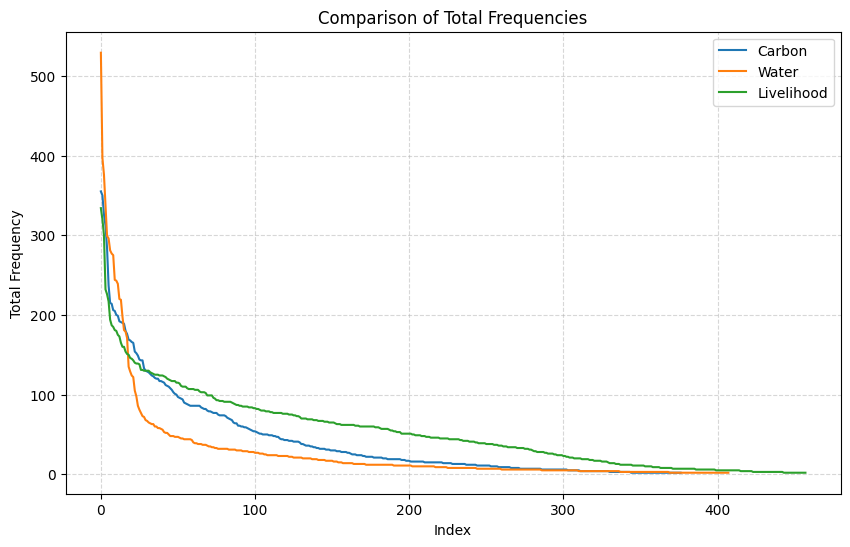

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(dairy_carbon_doc_with_frequencies['Total Freq'], label='Carbon')
plt.plot(dairy_water_doc_with_frequencies['Total Freq'], label='Water')
plt.plot(dairy_livelihood_doc_with_frequencies['Total Freq'], label='Livelihood')

plt.xlabel("Index")
plt.ylabel("Total Frequency")
plt.title("Comparison of Total Frequencies")

plt.legend()

plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

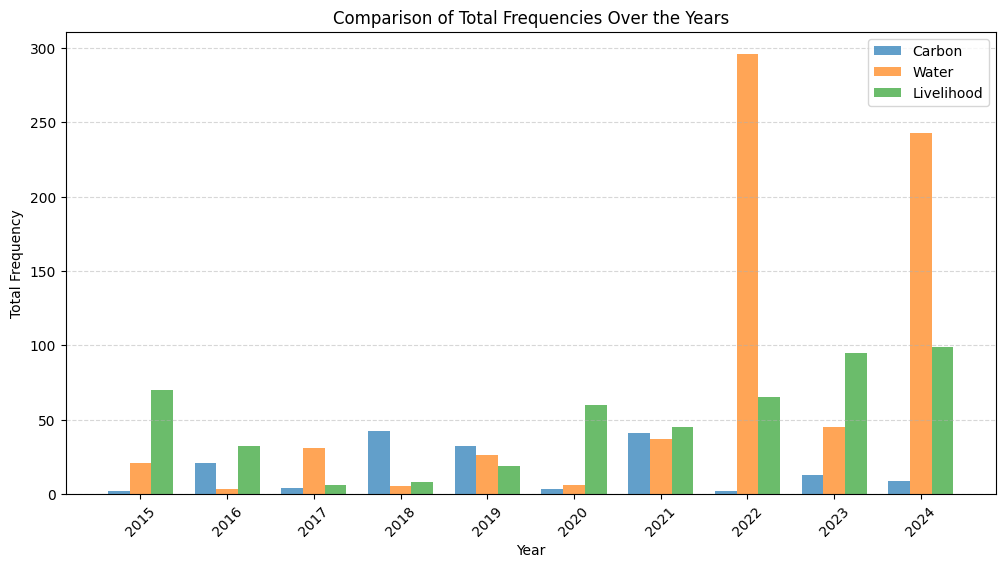

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

# Ensure sorting by Year before processing
dairy_carbon_doc_with_frequencies = dairy_carbon_doc_with_frequencies.sort_values(by="Year")
dairy_water_doc_with_frequencies = dairy_water_doc_with_frequencies.sort_values(by="Year")
dairy_livelihood_doc_with_frequencies = dairy_livelihood_doc_with_frequencies.sort_values(by="Year")

# Get unique years from all datasets
years = sorted(set(dairy_carbon_doc_with_frequencies["Year"]).union(
               set(dairy_water_doc_with_frequencies["Year"])).union(
               set(dairy_livelihood_doc_with_frequencies["Year"])))

# Convert to a dictionary for quick lookup
carbon_dict = dairy_carbon_doc_with_frequencies.set_index("Year")["Total Freq"].to_dict()
water_dict = dairy_water_doc_with_frequencies.set_index("Year")["Total Freq"].to_dict()
livelihood_dict = dairy_livelihood_doc_with_frequencies.set_index("Year")["Total Freq"].to_dict()

# Fill missing years with 0
carbon_freq = [carbon_dict.get(year, 0) for year in years]
water_freq = [water_dict.get(year, 0) for year in years]
livelihood_freq = [livelihood_dict.get(year, 0) for year in years]

# Define bar width and x positions
bar_width = 0.25
x = np.arange(len(years))

# Plot grouped bar chart
plt.bar(x - bar_width, carbon_freq, width=bar_width, label="Carbon", alpha=0.7)
plt.bar(x, water_freq, width=bar_width, label="Water", alpha=0.7)
plt.bar(x + bar_width, livelihood_freq, width=bar_width, label="Livelihood", alpha=0.7)

# Labels and Title
plt.xlabel("Year")
plt.ylabel("Total Frequency")
plt.title("Comparison of Total Frequencies Over the Years")
plt.xticks(x, years, rotation=45)  # Set x-axis labels to years, rotated for better visibility

# Display legend
plt.legend()

# Grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Show the plot
plt.show()

# Top 100 - Documents with more than 100 term frequency

In [36]:
carbon100 = []
for _,row in dairy_carbon_doc_with_frequencies.iterrows():
    if row["Total Freq"] >= 100:
        carbon100.append(row)

carbon100df = pd.DataFrame(carbon100)
print(len(carbon100df))

50


In [37]:
water100 = []
for _,row in dairy_water_doc_with_frequencies.iterrows():
    if row["Total Freq"] >= 100:
        water100.append(row)

water100df = pd.DataFrame(water100)
print(len(water100df))

23


In [38]:
livelihood100 = []
for _,row in dairy_livelihood_doc_with_frequencies.iterrows():
    if row["Total Freq"] >= 100:
        livelihood100.append(row)

livelihood100df = pd.DataFrame(livelihood100)
print(len(livelihood100df))

69


In [41]:
combined_files = pd.concat([
    carbon100df['File Name'],
    water100df['File Name'],
    livelihood100df['File Name']
]).unique().tolist()

print(len(combined_files))

133


In [43]:
combined_files = pd.DataFrame(combined_files)
combined_files.to_excel(r'final transcripts.xlsx')